Objective: Make a selection of nine paintings for the exhibition catalogue to be selected from Wikidata and rendered multi-format in Quarto.

The below Python code uses SPARQLWrapper to retrieve data from Wikidata based on a SPARQL query.

Wikidata link: [http://www.wikidata.org/entity/Q9395954](http://www.wikidata.org/entity/Q9395954)

Title: Thomas of Villanova heals the sick

Year: 1675

Creator: Bartolomé Esteban Murillo

Copyright: public domain



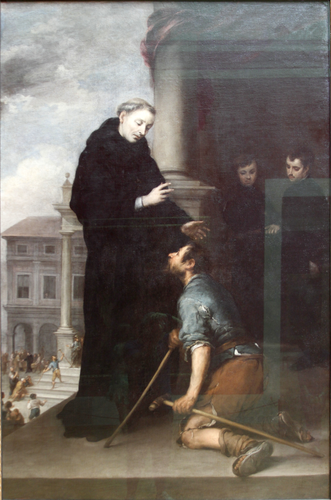




Wikidata link: [http://www.wikidata.org/entity/Q10901792](http://www.wikidata.org/entity/Q10901792)

Title: Midas and Bacchus

Year: 1624

Creator: Nicolas Poussin

Copyright: public domain



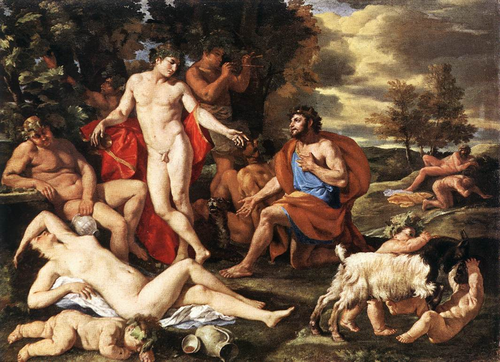




Wikidata link: [http://www.wikidata.org/entity/Q11772156](http://www.wikidata.org/entity/Q11772156)

Title: The Little Fruit Seller

Year: 1670

Creator: Bartolomé Esteban Murillo

Copyright: public domain



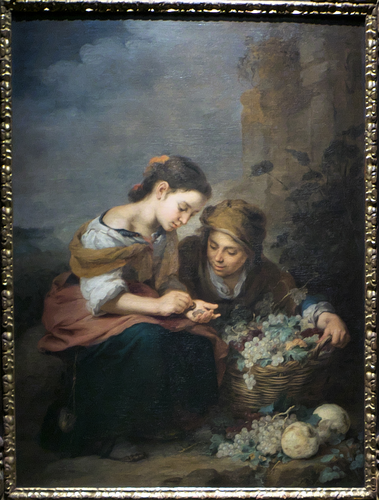

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import requests

# VARIABLES

sparql_endpoint_url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
wikibase_url = 'https://www.wikidata.org'
api_url = '/w/api.php'

# Wikidata requires a user agent header to prevent spam requests
user_agent = 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'

# SPARQL query
# see in Wikidata's Query Service GUI at:
# https://query.wikidata.org/#%23defaultView%3AImageGrid%0ASELECT%20%3Fitem%20%3FitemLabel%20%3Finceptionyear%20%3Fcreator%20%3FcreatorLabel%20%3Fcopyright%20%3FcopyrightLabel%20%3Fimage%0AWHERE%0A%7B%0A%20%20%23%20find%20items%20which%3A%0A%20%20%23%20are%20instances%20of%20%28wdt%3AP31%29%20paintings%20%28wd%3AQ3305213%29%0A%20%20%23%20have%20the%20property%20%28wdt%3AP195%29%20of%20being%20in%20collection%20wd%3AQ812285%20%28Bavarian%20State%20Painting%20Collections%20https%3A%2F%2Fwww.wikidata.org%2Fwiki%2FWikidata%3AWikiProject_sum_of_all_paintings%2FCollection%2FBavarian_State_Painting_Collections%29%0A%20%20%3Fitem%20wdt%3AP31%20wd%3AQ3305213%20.%0A%20%20%3Fitem%20wdt%3AP195%20wd%3AQ812285%20.%0A%20%20%23%20get%20the%20item%27s%20creator%20property%20%28wdt%3AP170%29%0A%20%20%3Fitem%20wdt%3AP170%20%3Fcreator%20.%0A%20%20%23%20get%20the%20item%27s%20image%20property%20%28wdt%3AP18%29%0A%20%20%3Fitem%20wdt%3AP18%20%3Fimage%20.%0A%20%20%23%20get%20the%20item%27s%20copyright%20status%20%28wdt%3AP6216%29%0A%20%20%3Fitem%20wdt%3AP6216%20%3Fcopyright%20.%20%0A%20%20%7B%0A%20%20%20%20%3Fitem%20wdt%3AP571%20%3Finception.%0A%20%20%20%20BIND%28YEAR%28%3Finception%29%20AS%20%3Finceptionyear%29%0A%20%20%7D%0A%0A%20%20%23%20filter%20out%20all%20paintings%20not%20created%20between%20the%20years%201600%20and%201700%0A%20%20FILTER%28%281600%20%20%3C%3D%20%3Finceptionyear%29%20%26%26%20%28%3Finceptionyear%20%3C%201700%20%29%29%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%7D%20%7D%0A%23%20limit%20to%20nine%20results%0ALIMIT%209
query = """
#defaultView:ImageGrid
SELECT ?item ?itemLabel ?inceptionyear ?creator ?creatorLabel ?copyright ?copyrightLabel ?image
WHERE
{
  # find items which:
  # are instances of (wdt:P31) paintings (wd:Q3305213)
  # have the property (wdt:P195) of being in collection wd:Q812285 (Bavarian State Painting Collections https://www.wikidata.org/wiki/Wikidata:WikiProject_sum_of_all_paintings/Collection/Bavarian_State_Painting_Collections)
  ?item wdt:P31 wd:Q3305213 .
  ?item wdt:P195 wd:Q812285 .
  # get the item's creator property (wdt:P170)
  ?item wdt:P170 ?creator .
  # get the item's image property (wdt:P18)
  ?item wdt:P18 ?image .
  # get the item's copyright status (wdt:P6216)
  ?item wdt:P6216 ?copyright . 
  {
    ?item wdt:P571 ?inception.
    BIND(YEAR(?inception) AS ?inceptionyear)
  }

  # filter out all paintings not created between the years 1600 and 1700
  FILTER((1600  <= ?inceptionyear) && (?inceptionyear < 1800 ))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } }
# limit to nine results
LIMIT 3
"""

# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

# MAIN PROGRAM

# create SPARQL query
sparql = SPARQLWrapper(sparql_endpoint_url, agent=user_agent)

# retrieve results and convert to JSON format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query().convert()

# for each result, print various data fields
for item in result['results']['bindings']:
    print('Wikidata link: ' + '[' + item['item']['value'] + ']' + '(' + item['item']['value'] + ')' + '\n')
    print('Title: ' + item['itemLabel']['value'] + '\n')
    print('Year: ' + item['inceptionyear']['value'] + '\n')
    print('Creator: ' + item['creatorLabel']['value'] + '\n')
    print('Copyright: ' + item['copyrightLabel']['value'] + '\n')

    # get image from image URL and display resized version
    image_url=item['image']['value']
    headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
    im = get_image(image_url, headers)
    im.thumbnail((500, 500), Image.Resampling.LANCZOS)
    display(im)
    print('\n\n')